# Loan Prediction using SmoteTomek

# Read Training Dataset

In [1]:
import pandas as pd
df_train = pd.read_csv('./Input/training_set.csv')
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


# Changing Credit History to object

In [2]:
crd_hst = []
for i in range(len(df_train)):
    if df_train['Credit_History'][i]==1:
        crd_hst.append('Yes')
    elif df_train['Credit_History'][i]==0:
        crd_hst.append('No')
    else:
        crd_hst.append(None)
df_train['Credit_History']=crd_hst

# Replacing Missing values

In [3]:
from definitions import replacer
replacer(df_train)

Missing Values replaced in DataFrame


# Defining X and Y

In [4]:
X = df_train.drop(labels=['Loan_ID','Loan_Status'],axis=1)
Y = df_train[['Loan_Status']]

In [5]:
Y.value_counts()

Loan_Status
Y              422
N              192
dtype: int64

# Data Preprocessing

In [6]:
from definitions import catconsep
cat, con =catconsep(X)

Categorical and Continuous variables appended


In [7]:
X1 = X[con]
X2 = pd.get_dummies(X[cat])
Xnew = X1.join(X2)

In [8]:
Xnew.shape

(614, 21)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Ynew = pd.DataFrame(le.fit_transform(Y.values.flatten()),columns=Y.columns)
Ynew

,Loan_Status
0,1
1,0
2,1
3,1
4,1
...,...
609,1
610,1
611,1
612,1


# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(Xnew, Ynew, test_size=0.2,random_state=21,stratify=Y)

# Using SMOTETomek on train data

In [11]:
from imblearn.combine import SMOTETomek
smtmk = SMOTETomek(random_state=42)
x_res , y_res = smtmk.fit_resample(xtrain,ytrain)

In [12]:
y_res.value_counts()

Loan_Status
0              287
1              287
dtype: int64

# Creating 5 RepeatedStratified Folds in train data

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=42)

# Training The Data on folds

In [14]:
from sklearn.metrics import roc_auc_score
import numpy as np
from catboost import CatBoostClassifier

clfs = []
scores = []

for i, (train_index, test_index) in enumerate(rskf.split(x_res, y_res)):
    x_train, x_val = x_res.iloc[train_index,:], x_res.iloc[test_index,:]
    y_train, y_val = y_res.iloc[train_index,:], y_res.iloc[test_index,:]
    cbc = CatBoostClassifier(iterations=1000,verbose=False)
    cbc.fit(x_train, y_train, eval_set = [(x_val, y_val)])
    preds = cbc.predict_proba(x_val)[:,-1]
    clfs.append(cbc)
    scr = roc_auc_score(y_val,preds)
    scores.append(scr)
    print('******************************')
    print('Fold : ',i , 'ROC AUC : ',round(scr,5))
print(f'\n\nMean score: {np.mean(scores)}')       

******************************
Fold :  0 ROC AUC :  0.90835
******************************
Fold :  1 ROC AUC :  0.89322
******************************
Fold :  2 ROC AUC :  0.88234
******************************
Fold :  3 ROC AUC :  0.91561
******************************
Fold :  4 ROC AUC :  0.90951
******************************
Fold :  5 ROC AUC :  0.88838
******************************
Fold :  6 ROC AUC :  0.81307
******************************
Fold :  7 ROC AUC :  0.93406
******************************
Fold :  8 ROC AUC :  0.94949
******************************
Fold :  9 ROC AUC :  0.94337
******************************
Fold :  10 ROC AUC :  0.88838
******************************
Fold :  11 ROC AUC :  0.90139
******************************
Fold :  12 ROC AUC :  0.8775
******************************
Fold :  13 ROC AUC :  0.93769
******************************
Fold :  14 ROC AUC :  0.89443
******************************
Fold :  15 ROC AUC :  0.88959
******************************
Fold

In [15]:
np.std(scores)

0.030632670254484455

In [16]:
np.std(scores)/np.mean(scores)

0.0339848974585725

# Evaluating Model based on Test Data

In [17]:
test_prob = []
for clf in clfs:
    pred = clf.predict_proba(xtest)
    test_prob.append(pred[:,1])

In [18]:
test_prob = np.stack(test_prob).mean(0)

In [19]:
test_pred = []
for i in test_prob:
    if i>=0.5:
        test_pred.append(1)
    else:
        test_pred.append(0)

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, test_prob)

0.7938080495356037

In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytest, test_pred))

              precision    recall  f1-score   support

           0       0.83      0.53      0.65        38
           1       0.82      0.95      0.88        85

    accuracy                           0.82       123
   macro avg       0.83      0.74      0.76       123
weighted avg       0.82      0.82      0.81       123



<AxesSubplot: >

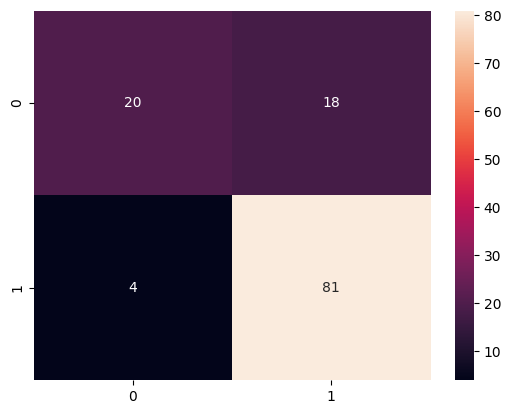

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cf = confusion_matrix(ytest,test_pred)
sb.heatmap(cf, annot=True)